In [103]:
# Installing pyspark

!pip install pyspark

In [104]:
# Importing packages

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import re
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import regexp_replace

In [105]:
# Creating necessary contents

ss=SparkSession.builder.getOrCreate()
sc=SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [106]:
# Importing and printing base data

base_data=ss.read.csv("/content/drive/MyDrive/BDA Mini Project/Thunderbird_2k.log_structured.csv",header=True)
base_data.show()

+------+-----+----------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+
|LineId|Label| Timestamp|      Date| User|    Time|   Location|      Component| PID|             Content|EventId|       EventTemplate|
+------+-----+----------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+
|     1|    -|1131566461|2005.11.09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session closed fo...|   E117|session closed fo...|
|     2|    -|1131566461|2005.11.09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session opened fo...|   E118|session opened fo...|
|     3|    -|1131566461|2005.11.09|dn228|12:01:01|dn228/dn228|          crond|2916|(root) CMD (run-p...|     E3|(root) CMD (run-p...|
|     4|    -|1131566461|2005.11.09|dn261|12:01:01|dn261/dn261|crond(pam_unix)|2907|session closed fo...|   E117|session closed fo...|
|     5|    -|1131566461|2005.11.09|dn261|12:01:01|dn26

In [107]:
# Count of total base data

base_data.count()

2000

In [108]:
# Checking for total number of null values

null_df = base_data.filter(base_data['Timestamp'].isNull() |  base_data['Date'].isNull() |  base_data['User'].isNull() | \
                           base_data['Time'].isNull()| base_data['Location'].isNull() | base_data['Component'].isNull() | \
                           base_data['PID'].isNull() | base_data['Content'].isNull() | base_data['EventId'].isNull() | \
                           base_data['EventTemplate'].isNull())
null_df.count()

255

In [109]:
# Checking for nulls (columnwise)

def check_null_cwise(column_name):
    return F.sum(F.col(column_name).isNull().cast('integer')).alias(column_name)

nulls_CWise = [check_null_cwise(col_name) for col_name in base_data.columns]

base_data.agg(*nulls_CWise).show()

+------+-----+---------+----+----+----+--------+---------+---+-------+-------+-------------+
|LineId|Label|Timestamp|Date|User|Time|Location|Component|PID|Content|EventId|EventTemplate|
+------+-----+---------+----+----+----+--------+---------+---+-------+-------+-------------+
|     0|    0|        0|   0|   0|   0|       0|        0|255|      0|      0|            0|
+------+-----+---------+----+----+----+--------+---------+---+-------+-------+-------------+



In [110]:
# Checking nulls in Process ID

pid_nulls_df = base_data.filter(~base_data['PID'].rlike(r'\s\d+$'))
pid_nulls_df.count()

1745

In [111]:
# Filling null values in Base_Dataframe with 0

base_data = base_data.na.fill({'PID': 0})


In [112]:
# Checking for nulls after filling null values

nulls_CWise = [check_null_cwise(col_name) for col_name in base_data.columns]

base_data.agg(*nulls_CWise).show()

+------+-----+---------+----+----+----+--------+---------+---+-------+-------+-------------+
|LineId|Label|Timestamp|Date|User|Time|Location|Component|PID|Content|EventId|EventTemplate|
+------+-----+---------+----+----+----+--------+---------+---+-------+-------+-------------+
|     0|    0|        0|   0|   0|   0|       0|        0|  0|      0|      0|            0|
+------+-----+---------+----+----+----+--------+---------+---+-------+-------+-------------+



In [113]:
# Checking for schema of  base data

base_data.printSchema()

root
 |-- LineId: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Component: string (nullable = true)
 |-- PID: string (nullable = false)
 |-- Content: string (nullable = true)
 |-- EventId: string (nullable = true)
 |-- EventTemplate: string (nullable = true)



In [114]:
# Since Timestamp column is in format of string we convert it into Timestamp format
# Using to_timestamp function

base_data=base_data.withColumn("Timestamp",F.to_timestamp(F.col("Time"),"hh:mm:ss"))
base_data.printSchema()

root
 |-- LineId: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Date: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Component: string (nullable = true)
 |-- PID: string (nullable = false)
 |-- Content: string (nullable = true)
 |-- EventId: string (nullable = true)
 |-- EventTemplate: string (nullable = true)



In [115]:
#Conversion of integer into date

base_data=base_data.withColumn("Date",F.to_date(F.col("Date"),"yyyy.MM.dd"))
base_data.printSchema()
base_data.show()

root
 |-- LineId: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Date: date (nullable = true)
 |-- User: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Component: string (nullable = true)
 |-- PID: string (nullable = false)
 |-- Content: string (nullable = true)
 |-- EventId: string (nullable = true)
 |-- EventTemplate: string (nullable = true)

+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+
|LineId|Label|          Timestamp|      Date| User|    Time|   Location|      Component| PID|             Content|EventId|       EventTemplate|
+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+
|     1|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|sess

In [116]:
# Month Extraction

base_data=base_data.withColumn("Month",F.month(F.col("Date")))
base_data.show()

+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+-----+
|LineId|Label|          Timestamp|      Date| User|    Time|   Location|      Component| PID|             Content|EventId|       EventTemplate|Month|
+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+-----+
|     1|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session closed fo...|   E117|session closed fo...|   11|
|     2|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session opened fo...|   E118|session opened fo...|   11|
|     3|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|          crond|2916|(root) CMD (run-p...|     E3|(root) CMD (run-p...|   11|
|     4|    -|1970-01-01 00:01:01|2005-11-09|dn261|12:01:01|dn261/dn261|crond(pam_unix)|2907|session

In [117]:
# Year Extraction

base_data=base_data.withColumn("Year",F.year(F.col("Date")))
base_data.show()

+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+-----+----+
|LineId|Label|          Timestamp|      Date| User|    Time|   Location|      Component| PID|             Content|EventId|       EventTemplate|Month|Year|
+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+-----+----+
|     1|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session closed fo...|   E117|session closed fo...|   11|2005|
|     2|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session opened fo...|   E118|session opened fo...|   11|2005|
|     3|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|          crond|2916|(root) CMD (run-p...|     E3|(root) CMD (run-p...|   11|2005|
|     4|    -|1970-01-01 00:01:01|2005-11-09|dn261|12:01:01|dn261/dn26

In [118]:
# After Preprocessing printing schema

base_data.printSchema()

root
 |-- LineId: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Date: date (nullable = true)
 |-- User: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Component: string (nullable = true)
 |-- PID: string (nullable = false)
 |-- Content: string (nullable = true)
 |-- EventId: string (nullable = true)
 |-- EventTemplate: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [119]:
base_data.groupBy("Location").count().show()

+-----------+-----+
|   Location|count|
+-----------+-----+
|dn125/dn125|    1|
|src@aadmin4|    8|
|cn250/cn250|    1|
|bn138/bn138|    3|
|dn210/dn210|    1|
|cn103/cn103|    2|
|cn296/cn296|    1|
|cn672/cn672|    1|
|cn991/cn991|    1|
|cn235/cn235|    1|
|bn857/bn857|    1|
|cn413/cn413|    1|
|cn763/cn763|    1|
|bn468/bn468|    1|
|cn974/cn974|    1|
|bn251/bn251|    1|
|cn518/cn518|    1|
|cn375/cn375|    1|
|cn500/cn500|    1|
|cn468/cn468|    1|
+-----------+-----+
only showing top 20 rows



In [120]:
base_data.groupBy("Component").count().show()

+--------------------+-----+
|           Component|count|
+--------------------+-----+
|                 VFS|    2|
|                CPU0|    1|
|                ide0|    1|
|              #NAME?|    1|
|              xinetd|   37|
|              time.c|    3|
|     crond(pam_unix)|   43|
|  IA32 emulation $Id|    1|
|            ts_fixup|    1|
|             usbcore|    4|
|              gmetad|   36|
|                ide3|    1|
|                mice|    1|
|               e1000|    3|
|                 ide|    1|
|                 CPU|   15|
|                scsi|    2|
|checking TSC sync...|    1|
|             nfslock|    1|
|              scsi0 |    1|
+--------------------+-----+
only showing top 20 rows



In [121]:
# Starting the process of clustering

# Using pipelining and prameter grids

# Using K-Means and Latent Dirichlet allocation Clustering Methods

In [122]:
# Importing necessary classes and packages

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import GaussianMixture

In [123]:
# Creating a copy of base_data

df=base_data

In [124]:
# Creating String indexers for multiple columns


component_indexer = StringIndexer(inputCol="Component", outputCol="component_index")

user_indexer = StringIndexer(inputCol="User", outputCol="user_index")

location_indexer = StringIndexer(inputCol="Location", outputCol="location_index")


In [125]:
# Creating a vector assembler

# Definign Input Columns

input_cols = ['component_index', 'user_index', 'location_index']

vector_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

In [126]:
# creating stages of pipeline

stages = [component_indexer, user_indexer, location_indexer, vector_assembler]

# Making a pipeline with available stages

pipeline = Pipeline(stages=stages)

In [127]:
# Fitting the complete data into pipeline

final_pipeline = pipeline.fit(df)
final_tranformed_data = final_pipeline.transform(df)
final_tranformed_data.show(5)

+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+
|LineId|Label|          Timestamp|      Date| User|    Time|   Location|      Component| PID|             Content|EventId|       EventTemplate|Month|Year|component_index|user_index|location_index|       features|
+------+-----+-------------------+----------+-----+--------+-----------+---------------+----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+
|     1|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session closed fo...|   E117|session closed fo...|   11|2005|            4.0|      24.0|          24.0|[4.0,24.0,24.0]|
|     2|    -|1970-01-01 00:01:01|2005-11-09|dn228|12:01:01|dn228/dn228|crond(pam_unix)|2915|session opened fo...|   E118|session opened fo...|   11

In [128]:
# Making train and test data

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [129]:
# Feature Assembling for train data

final_pipeline_train = pipeline.fit(train_data)
final_train = final_pipeline_train.transform(train_data)
final_train.select('features').show(5)

+-----------------+
|         features|
+-----------------+
|  [4.0,15.0,15.0]|
|  [4.0,72.0,72.0]|
|[1.0,235.0,235.0]|
|  [1.0,43.0,43.0]|
|[1.0,287.0,287.0]|
+-----------------+
only showing top 5 rows



In [130]:
# Feature Assembling for test data

final_pipeline_test = pipeline.fit(test_data)
final_test = final_pipeline_test.transform(test_data)
final_test.select('features').show(5)

+---------------+
|       features|
+---------------+
|      (3,[],[])|
|      (3,[],[])|
|      (3,[],[])|
|  [7.0,3.0,3.0]|
|[1.0,37.0,35.0]|
+---------------+
only showing top 5 rows



In [131]:
# Defining k values and cost

k_values = range(2, 10)
costs_kmeans = []

In [132]:
# Finding the training cost for K-Means Algorithm

for i in k_values:
    kmeans = KMeans(k=i, seed=1, featuresCol='features')
    model_kmeans = kmeans.fit(final_train)
    cost_kmeans = model_kmeans.summary.trainingCost
    costs_kmeans.append(cost_kmeans)

In [133]:
# Conversion of training costs corresponding to number of clusters

costs_array_kmeans = np.array(costs_kmeans)
costs_array_kmeans

array([5329043.74087472, 2242089.39368239, 1219359.00841956,
        758081.9546324 ,  540650.76752293,  423667.24487665,
        350226.93691154,  296501.30209044])

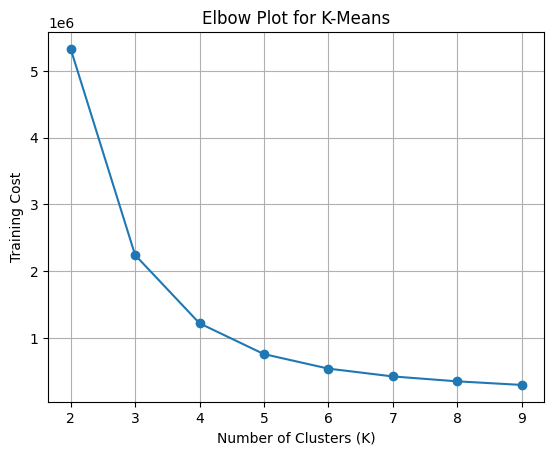

In [134]:
# Elbow plot for K-Means Model

plt.plot(k_values, costs_kmeans, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Training Cost')
plt.title('Elbow Plot for K-Means')
plt.grid(True)
plt.show()

In [135]:
# Defining k-means model

kmeans = KMeans()

In [136]:
# Building a paramGrid to identify best parameters

paramGrid_kmeans = ParamGridBuilder() \
    .addGrid(kmeans.k, [3, 5, 7]) \
    .addGrid(kmeans.maxIter, [3, 5, 10]) \
    .addGrid(kmeans.seed, [1, 3, 5]) \
    .build()

In [137]:
# Creating a cross validator

crossval_kmeans = CrossValidator(estimator=kmeans, estimatorParamMaps=paramGrid_kmeans, \
                      evaluator=ClusteringEvaluator(),
                      numFolds=5)

In [154]:
# Finding best model with various combinations of paramters

cvModel_kmeans = crossval_kmeans.fit(final_train)
best_model_kmeans = cvModel_kmeans.bestModel
predictions_kmeans = best_model_kmeans.transform(final_test)
predictions_kmeans.show(5)

+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+----------+
|LineId|Label|          Timestamp|      Date|        User|    Time|          Location|           Component|  PID|             Content|EventId|       EventTemplate|Month|Year|component_index|user_index|location_index|       features|prediction|
+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+----------+
|   100|    -|1970-01-01 00:01:31|2005-11-09|tbird-admin1|12:01:31|local@tbird-admin1|/apps/x86_64/syst...| 1682|data_thread() got...|    E32|data_thread() got...|   11|2005|            0.0|       0.0|           0.0|      (3,[],[])|         0|
|  1003|    -|1970-01-01

In [139]:
# Finding the K value of best model

best_modelK = best_model_kmeans.getK()
print(best_modelK)

3


In [140]:
# Creating a clustering evaluator

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions_kmeans)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.8197286418396971


In [141]:
# Convertion of clusters

from pyspark.sql.functions import when

predictions_kmeans = predictions_kmeans.withColumn('prediction',
    when(predictions_kmeans['prediction'] == "0", 'Cluster 1')
    .when(predictions_kmeans['prediction'] == "1", 'Cluster 2')
    .otherwise('Cluster 3')
)

predictions_kmeans.show(5)

+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+----------+
|LineId|Label|          Timestamp|      Date|        User|    Time|          Location|           Component|  PID|             Content|EventId|       EventTemplate|Month|Year|component_index|user_index|location_index|       features|prediction|
+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+----------+
|   100|    -|1970-01-01 00:01:31|2005-11-09|tbird-admin1|12:01:31|local@tbird-admin1|/apps/x86_64/syst...| 1682|data_thread() got...|    E32|data_thread() got...|   11|2005|            0.0|       0.0|           0.0|      (3,[],[])| Cluster 1|
|  1003|    -|1970-01-01

In [142]:
# Converting into a pandas datatype to plot

predictions_kmeans_pandas=predictions_kmeans.toPandas()

In [155]:
# Identifying the  number of inputs

print(predictions_kmeans.count())

358


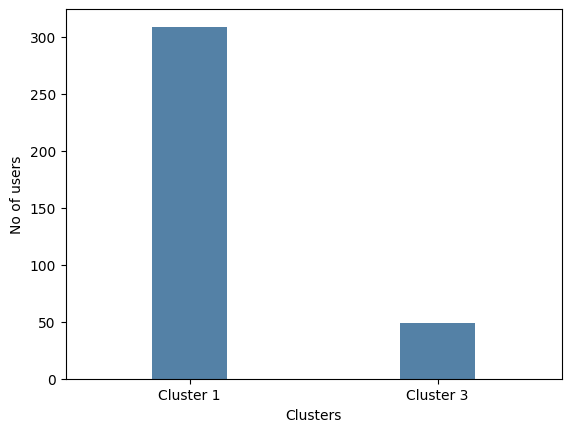

In [164]:
# Visualizing clusters


prediction_counts = predictions_kmeans_pandas['prediction'].value_counts()
sns.barplot(x=predictions_clusters.index, y=prediction_counts.values, color='steelblue', width=0.3)
plt.xlabel('Clusters')
plt.ylabel('No of users')
plt.show()

In [144]:
# Defining gmx model

gmx = GaussianMixture()

In [145]:
# Building a paramGrid to identify best parameters

paramGrid_gmx = ParamGridBuilder() \
    .addGrid(gmx.k, [2, 3, 5, 7]) \
    .addGrid(gmx.aggregationDepth, [3, 5]) \
    .addGrid(gmx.maxIter, [2, 5, 7, 10]) \
    .build()

In [146]:
# Creating a cross validator

crossval_gmx = CrossValidator(estimator=gmx, estimatorParamMaps=paramGrid_gmx, \
                      evaluator=ClusteringEvaluator(), \
                      numFolds=5)

In [147]:
# Finding best model with various combinations of paramters

cvModel_gmx = crossval_gmx.fit(final_train)
best_model_gmx = cvModel_gmx.bestModel
predictions_gmx = best_model_gmx.transform(final_test)
predictions_gmx.show(5)

+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+--------------------+----------+
|LineId|Label|          Timestamp|      Date|        User|    Time|          Location|           Component|  PID|             Content|EventId|       EventTemplate|Month|Year|component_index|user_index|location_index|       features|         probability|prediction|
+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+--------------------+----------+
|   100|    -|1970-01-01 00:01:31|2005-11-09|tbird-admin1|12:01:31|local@tbird-admin1|/apps/x86_64/syst...| 1682|data_thread() got...|    E32|data_thread() got...|   11|2005|            0.0|       0.0|    

In [148]:
# Finding the K value of best model

best_modelK = best_model_gmx.getK()
print(best_modelK)

3


In [149]:
# Creating a clustering evaluator

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions_gmx)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6978390971331095


In [150]:
# Convertion of clusters

from pyspark.sql.functions import when

predictions_gmx = predictions_gmx.withColumn('prediction',
    when(predictions_gmx['prediction'] == "0", 'Cluster 1')
    .when(predictions_gmx['prediction'] == "1", 'Cluster 2')
    .otherwise('Cluster 3')
)

predictions_gmx.show(5)

+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+--------------------+----------+
|LineId|Label|          Timestamp|      Date|        User|    Time|          Location|           Component|  PID|             Content|EventId|       EventTemplate|Month|Year|component_index|user_index|location_index|       features|         probability|prediction|
+------+-----+-------------------+----------+------------+--------+------------------+--------------------+-----+--------------------+-------+--------------------+-----+----+---------------+----------+--------------+---------------+--------------------+----------+
|   100|    -|1970-01-01 00:01:31|2005-11-09|tbird-admin1|12:01:31|local@tbird-admin1|/apps/x86_64/syst...| 1682|data_thread() got...|    E32|data_thread() got...|   11|2005|            0.0|       0.0|    

In [151]:
# Converting into a pandas datatype to plot

predictions_gmx_pandas=predictions_gmx.toPandas()

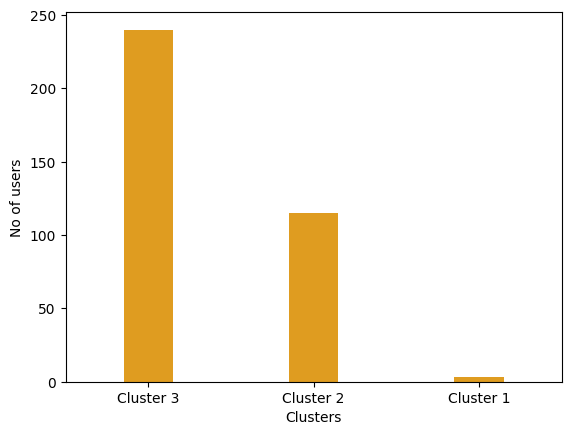

In [160]:
# Plotting Datas and corresponding clusters

prediction_counts = predictions_gmx_pandas['prediction'].value_counts()
sns.barplot(x=predictions_clusters.index, y=prediction_counts.values, color='orange', width=0.3)
plt.xlabel('Clusters')
plt.ylabel('No of users')
plt.show()
